In [31]:
import os
import numpy as np
from matplotlib import pyplot as plt
import re

#### Using HeFESTo lookup table in aspect

In this note book, I'll show how to:

* a. Import a HeFESTo lookup table
* b. Plot This lookup table
* c. Estimate the amount of density change and latent heat generation on a mantle adiabat
* d. convert to a "perplex" lookup table readable by aspect
* e. Maintain a workflow using the lookup table, including how to check your implementation.

Note on the example lookup table I use:
(todo)

#### Step 1: Define a class to read in a lookup table

Here I will first define a class to read the header and the contents of a lookup table.
Upon calling the member function, this class saves the information of the header and the data into class objects.
Later on, I will include more features in the class to perform other operations, thus I only call this class "HEFESTO_0" here.

The header information is saved in a dictionary while is printed at the end of the cell below.
The data is saved into a 2d numpy array.

In [32]:
def ReadHeader(fin):
    '''
    Read header information from file.
    An example of string is:
        'P	   Depth  T(K)'
    Inputs:
        fin: a file handler (read)
    Returns:
        _header(dict): header information
            key(dict): infomation under this key:
                'col':
                    column in file
                'unit':
                    unit of this variable
    '''
    header = {}
    first_line = fin.readline()
    entries = first_line.split(' ')
    i = 0
    for entry in entries:
        entry = entry.strip(' \t\n')
        if len(entry) > 0:
            col = i
            temp = entry.split('(')
            _name = temp[0].strip(' \t')
            if len(temp) == 1:
                unit = None
            elif len(temp) == 2:
                temp1 = temp[1].lstrip(' \t')
                unit = temp1.strip(' \t)')
            else:
                raise ValueError("Entry %s is not understood" % entry)
            header[_name] = {'unit': unit, 'col': i}
            i += 1
    header['total'] = i # total number of columns in file
    return header


class HEFESTO_0():

    def __init__(self):
        '''
        initiate class
        '''
        self.header = {}
        self.data = []
        self.version = "1.0.0"
        self.min1 = 0.0 
        self.delta1 = 0.0 
        self.number1 = 0
        self.min2 = 0.0
        self.delta2 = 0.0
        self.number2 = 0
        self.indexes = []  # indexes of output data
        self.number_out1 = 0 # number of output
        self.number_out2 = 0
        self.delta_out1 = 0.0  # intervals used to outptu
        self.delta_out2 = 0.0 
        self.oheader = { 'Temperature': 'T(K)',  'Pressure': 'P(bar)' ,  'Density': 'rho,kg/m3',\
        'Thermal_expansivity': 'alpha,1/K', 'Isobaric_heat_capacity': 'cp,J/K/kg',\
        'VP': 'vp,km/s', 'VS': 'vs,km/s', 'Enthalpy': 'h,J/kg' }
        # unit to output
        self.ounit = {'Temperature': 'K', 'Pressure': 'bar', 'Thermal_expansivity': '1/K',\
        'Isobaric_heat_capacity': 'J/K/kg', 'Density': 'kg/m3', 'VP':'km/s', 'VS':'km/s', 'Enthalpy': 'J/kg'}

    def read_table(self, path):
        '''
        read data
        '''
        print("Reading Header: %s" % path)
        with open(path, 'r') as fin:
            self.header = ReadHeader(fin)

        print("Reading Data: %s" % path)
        self.data = np.genfromtxt(path, skip_header=1, comments='#', filling_values=0.0)


hfile = "./pyrolite.56"  # todo  
assert(os.path.isfile(hfile))
# call processfunction
Hefesto = HEFESTO_0()
Hefesto.read_table(hfile)
print("File header: ")
print(Hefesto.header)  # debug
print("Size of file data")
print(Hefesto.data.shape)

Reading Header: ./pyrolite.56
Reading Data: ./pyrolite.56
File header: 
{'Pressure': {'unit': 'GPa', 'col': 0}, 'Depth': {'unit': None, 'col': 1}, 'Temperature': {'unit': 'K', 'col': 2}, 'Density': {'unit': None, 'col': 3}, 'vb': {'unit': None, 'col': 4}, 'vs': {'unit': None, 'col': 5}, 'vp': {'unit': None, 'col': 6}, 'vsq': {'unit': None, 'col': 7}, 'vpq': {'unit': None, 'col': 8}, 'Entropy': {'unit': None, 'col': 9}, 'Q_S': {'unit': None, 'col': 10}, 'cp': {'unit': None, 'col': 11}, 'total': 12}
Size of file data
(113481, 12)


##### Step 2: Plot the lookup table in P, T space

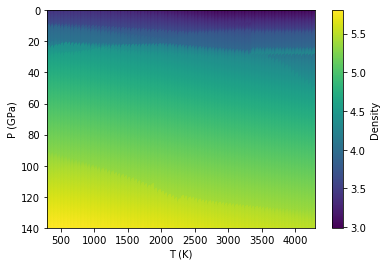

In [33]:
col_P = Hefesto.header['Pressure']['col']
Ps = Hefesto.data[:, col_P]
col_T = Hefesto.header['Temperature']['col']
Ts = Hefesto.data[:, col_T]
col_density = Hefesto.header['Density']['col']
Densities = Hefesto.data[:, col_density]
Tmin = np.min(Ts)
Tmax = np.max(Ts)
Pmin = np.min(Ps)
Pmax = np.max(Ps)
fig, ax = plt.subplots()

h = ax.scatter(Ts, Ps, c=Densities)
ax.set_xlabel("T (K)")
ax.set_xlim([Tmin, Tmax])
ax.set_ylabel("P (GPa)")
ax.set_ylim([Pmin, Pmax])
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="Density")

#### Step 3 convert to a perplex table

(todo) 

In [34]:
def ReadFirstDimension(nddata):
    '''
    Process the data in the fisrt dimension(min, delta, number)
    
    Inputs:
        nddata: a ndarray of the first dimension data
    Returns:
        min: min value
        delta: data interval
        number: number in a column
    '''
    # min value
    min = nddata[0]
    # delta
    delta = nddata[1] - nddata[0]
    # number
    number = nddata.size
    for i in range(0, nddata.size-1):
        if nddata[i] > nddata[i+1]:
            number = i + 1
            break
    return min, delta, number


def ReadSecondDimension(nddata):
    '''
    Process the data in the second dimension(min, delta, number)
    
    Inputs:
        nddata: a ndarray of the first dimension data
    Returns:
        min: min value
        delta: data interval
        number: number in a column
    '''
    # min value
    min = nddata[0]
    # delta
    tolerance = 1e-6
    delta = 0.0
    for i in range(0, nddata.size-1):
        if abs(nddata[i] - nddata[i+1]) / abs(nddata[i]) > tolerance:
            delta = nddata[i+1] - nddata[i]
            sub_size = i + 1
            break
    # number
    assert(nddata.size % sub_size == 0) # assert the table is regular(rectangle)
    number = nddata.size // sub_size
    print('first dimension: ', sub_size, ", second dimension: ", number, ", total size: ", nddata.size)
    return min, delta, number


class HEFESTO_1(HEFESTO_0):

    # todo
    def __init__(self):
        HEFESTO_0.__init__(self)
        # todo header for table outputs
        self.oheader = { 'Temperature': 'T(K)',  'Pressure': 'P(bar)' ,  'Density': 'rho,kg/m3',\
        'Thermal_expansivity': 'alpha,1/K', 'cp': 'cp,J/K/kg',\
        'vp': 'vp,km/s', 'vs': 'vs,km/s', 'Enthalpy': 'h,J/kg' }
    
    def Process(self, field_names, o_path, **kwargs):
        '''
        Process the Hefesto lookup table for aspect
    
        Inputs:
            o_path: a output path
            kwargs: options
                interval1 & 2: interval in the first & second dimension
        Outputs:
            Output of this function is the Perplex file form that could be recognized by aspect
        Returns:
            -
        '''
        # read dimension info
        first_dimension_name = kwargs.get('first_dimension', field_names[0])
        second_dimension_name = kwargs.get('second_dimension', field_names[1])
        col_first = self.header[first_dimension_name]['col']
        col_second = self.header[second_dimension_name]['col']
        self.min1, self.delta1, self.number1 = ReadFirstDimension(self.data[:, col_first])
        self.min2, self.delta2, self.number2 = ReadSecondDimension(self.data[:, col_second])
        # output
        interval1 = kwargs.get('interval1', 1)
        interval2 = kwargs.get('interval2', 1)
        self.indexes = self.IndexesByInterval(interval1, interval2)  # work out indexes
        self.number_out1 = int(np.ceil(self.number1 / interval1)) # number of output
        self.number_out2 = int(np.ceil(self.number2 / interval2))
        # output intervals
        self.delta_out1 = self.delta1 * interval1 # output intervals
        self.delta_out2 = self.delta2 * interval2 # output intervals
        self.OutputHefesto(field_names, o_path)
    
    def IndexesByInterval(self, interval1, interval2):
        '''
        Work out indexes by giving interval(default is 1, i.e. consecutive)
        '''
        assert(type(interval1) == int and type(interval2) == int)
        # indexes in 
        indexes_1 = range(0, self.number1, interval1) 
        indexes_2 = range(0, self.number2, interval2)
        # work out the overall indexes
        indexes = []
        for index_2 in indexes_2:
            for index_1 in indexes_1: 
                indexes.append(index_1 + self.number1 * index_2)
        return indexes
    
    
    def OutputHefesto(self, field_names, o_path):
        '''
        Process the Hefesto lookup table for aspect
    
        Inputs:
            odata: data to be outputed
            o_path: a output path
            kwargs: options
                version: version of this file
            field_names: field_name to output, the first two are the first and second dimension
        Outputs:
            Output of this function is the Perplex file form that could be recognized by aspect
        Returns:
            -
        '''
        print("Outputing Data: %s" % o_path)
        # columns
        print("Outputing fields: %s" % field_names)  # debug
        print('first dimension: ', self.number_out1, ", second dimension: ", self.number_out2, ", size:", self.number_out1 * self.number_out2)
        assert(len(field_names) >= 2)
        columns = []

        # UnitConvert = UNITCONVERT()
        missing_last = self.data.shape[1]
        missing_fix_values = []
        for field_name in field_names:
            # attach size(field_names) if failed
            try:
                columns.append(self.header[field_name]['col'])
            except KeyError:
                # first check that T or P is not missing
                # then append an imaginary column
                if field_name == 'Temperature':
                    raise KeyError('Abort: Temperature field is missing')
                elif field_name == 'Pressure':
                    raise KeyError('Abort: Pressure field is missing')
                else:
                    # assign an append value
                    print('field %s is missing, going to append manually' % field_name)
                    columns.append(missing_last)
                    missing_last += 1
                    # ask for value
                    missing_fix_value = float(input('Input value:'))
                    missing_fix_values.append(missing_fix_value)
        unit_factors = []
        for field_name in field_names:
            # attach 1 if failed
            unit_factors.append(1.0)
        # check the output values
        # note that self.indexes[self.number_out1] gives the index of the second member in the second dimension
        tolerance = 1e-5
        temp1 = self.data[self.indexes[1], columns[0]] - self.data[self.indexes[0], columns[0]]
        temp2 = self.data[self.indexes[self.number_out1], columns[1]] - self.data[self.indexes[0], columns[1]]  
        assert(abs(temp1 - self.delta_out1) / self.delta_out1 < tolerance)
        assert(abs(temp2 - self.delta_out2) / self.delta_out2 < tolerance)
        # mend self.data if needed
        if missing_last > self.data.shape[1]:
            print("Concatenating missing data")
            new_data = np.ones((self.data.shape[0], missing_last - self.data.shape[1])) *  missing_fix_values
            self.data = np.concatenate((self.data, new_data), axis=1)
        # output
        with open(o_path, 'w') as fout: 
            fout.write(self.version + '\n')  # version
            fout.write(os.path.basename(o_path) + '\n') # filenamea
            fout.write('2\n')  # dimension
            fout.write('%s\n' % self.oheader[field_names[0]])
            fout.write('\t%.8f\n' % (float(self.min1) * unit_factors[0])) # min value
            fout.write('\t%.8f\n' % (float(self.delta_out1) * unit_factors[0]))  # difference, use the output value
            fout.write('\t%s\n' % self.number_out1)  # number of output
            fout.write('%s\n' % self.oheader[field_names[1]])
            fout.write('\t%.8f\n' % (float(self.min2) * unit_factors[1]))
            fout.write('\t%.8f\n' % (float(self.delta_out2) * unit_factors[1]))
            fout.write('\t%s\n' % self.number_out2)
            fout.write('\t%s\n' % len(columns))
            temp = ''
            for field_name in field_names:
                temp += '%-20s' % self.oheader[field_name]
            temp += '\n'
            fout.write(temp)
            # data is indexes, so that only part of the table is output
            np.savetxt(fout, self.data[np.ix_(self.indexes, columns)] * unit_factors, fmt='%-19.8e')
        print("New file generated: %s" % o_path) 


ofile = "./pyrolite_perplex"
Hefesto = HEFESTO_1()
Hefesto.read_table(hfile)
# fields to read in
# field_names = ['Pressure', 'Temperature', 'Density', 'Thermal_expansivity', 'Isobaric_heat_capacity', 'VP', 'VS', 'Enthalpy']
field_names = ['Pressure', 'Temperature', 'Density', 'cp', 'vp', 'vs']  # todo
Hefesto.Process(field_names, ofile)
# assert something 
assert(os.path.isfile(ofile))

Reading Header: ./pyrolite.56
Reading Data: ./pyrolite.56
first dimension:  1401 , second dimension:  81 , total size:  113481
Outputing Data: ./pyrolite_perplex
Outputing fields: ['Pressure', 'Temperature', 'Density', 'cp', 'vp', 'vs']
first dimension:  1401 , second dimension:  81 , size: 113481
New file generated: ./pyrolite_perplex


#### Assign interval values to make the output table smaller

By doing this, we can choose arbitary resolution in the lookup table and save the cost of RAM when running aspect.
(todo)